# import packages

In [74]:
from itertools import permutations, product

import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, auc, confusion_matrix, balanced_accuracy_score, precision_recall_curve, auc, roc_curve, roc_auc_score, f1_score, recall_score, precision_score
from sklearn.inspection import permutation_importance
from sklearn import preprocessing

from sklearn.neural_network import MLPClassifier

from imblearn.ensemble import BalancedBaggingClassifier
import xgboost as xgb
from xgboost import XGBClassifier

import numpy as np
from numpy import mean,std
from sklearn.model_selection import GridSearchCV

import pickle

from ctgan import CTGANSynthesizer
from mlxtend.classifier import StackingCVClassifier

from os import path

import matplotlib.pyplot as plt

from warnings import simplefilter
from collections import OrderedDict
from sklearn.svm import SVC

if (os.path.abspath('').split('/')[-1] == 'project'):
    %cd utils
elif (os.path.abspath('').split('/')[-1] == 'train_and_vis'):
    %cd ../utils

import query_utils
import model_utils
import validation_utils
import data_utils

if (os.path.abspath('').split('/')[-1] == 'utils'):
    %cd ..


simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

/Users/benjaminli/Documents/coding/scires/project/utils
/Users/benjaminli/Documents/coding/scires/project


### Synthetic Data creation
Performed with CTGANSynthesizer

In [2]:
isZoonotic = df.loc[df['isZoonotic']==1][:1200]
isZoonotic = isZoonotic.loc[:, isZoonotic.columns != 'isZoonotic']
print(isZoonotic)

posGanModel = CTGANSynthesizer(batch_size=60, epochs=10, verbose=True)
posGanModel.fit(isZoonotic)

# check if current model is better than pickled model
posGanModel.save('models/curr_models/posGanModel.pkl')

notZoonotic = df.loc[df['isZoonotic']==0][:3000]
notZoonotic = isZoonotic.loc[:, isZoonotic.columns != 'isZoonotic']
print(notZoonotic)

negGanModel = CTGANSynthesizer(batch_size=60, epochs=10, verbose=True)
negGanModel.fit(notZoonotic)
negGanModel.save('models/curr_models/negGanModel.pkl')

NameError: name 'df' is not defined

# Dataset retrieval
Workings of the function is packaged into data_utils (for readability). Data is generated within "process_data.ipynb".

In [2]:
datasets = data_utils.retrieveAllDatasets()

working directory: /Users/benjaminli/Documents/coding/scires/project
kmer: 3
zhang reg 9329
zhang norm 9329
nardus reg 1848
nardus norm 1848
merge reg 10676
merge norm 10676
kmer: 4
zhang reg 9329
zhang norm 9329
nardus reg 1848
nardus norm 1848
merge reg 10676
merge norm 10676
kmer: 5
zhang reg 9329
zhang norm 9329
nardus reg 1848
nardus norm 1848
merge reg 10676
merge norm 10676
kmer: 6
zhang reg 9329
zhang norm 9329
nardus reg 1848
nardus norm 1848
merge reg 10676
merge norm 10676


# TODO

### Generate & validate performance of KNN (baseline) on dataset

In [77]:
kmer = 4
ds = datasets['merged'][f'normalized-{kmer}']

X_train, X_test = ds['X_train'], ds['X_test']

X = pd.concat([X_train, X_test])
y = np.concatenate([ds['y_train'], ds['y_test']], axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
param = {
    'n_neighbors': [1, 3, 5, 7, 9]
}

knntest = BalancedBaggingClassifier(base_estimator=GridSearchCV(KNeighborsClassifier(n_neighbors = 1, n_jobs = -1), param_grid=param, verbose=10), n_estimators = 10, n_jobs = -1)

knntest.fit(X_train, y_train)
print(knntest.score(X_test, y_test))
print((y_test, knntest.predict(X_test)))
print(confusion_matrix(y_test, knntest.predict(X_test)).ravel())

pickle.dump(knntest, open('models/curr_models/knn.pkl', 'wb'))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START n_neighbors=1...............................................
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START n_neighbors=1...............................................
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START n_neighbors=1...............................................
[CV 1/5; 1/5] END ................n_neighbors=1;, score=0.899 total time=   0.0s
[CV 2/5; 1/5] START n_neighbors=1...............................................
[CV 1/5; 1/5] END ................n_neighbors=1;, score=0.890 total time=   0.0s
[CV 2/5; 1/5] START n_neighbors=1...............................................
[CV 1/5; 1/5] END ................n_neighbors=1;, score=0.927 total time=   0.0s
[CV 2/5; 1/5] START n_neighbors=1...............................................
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START n_neighbors

In [ ]:
predictions = knntest.predict(X_test)
picklething = pickle.load(open('models/curr_models/kmer4/knn.pkl', 'rb'))
picklescore = validation_utils.cross_validate(picklething, X_test, y_test)
# print(knntest, picklescore)
# saveModel(knntest, "knn", X_test, y_test)

In [20]:
print(picklescore)

0.826


### Evaluate & validate performance of random forest (baseline) on dataset

In [16]:
kmer = 4
ds = datasets['merged'][f'normalized-{kmer}']

X_train, y_train, X_test, y_test = ds['X_train'], ds['y_train'], ds['X_test'], ds['y_test']

X = pd.concat([X_train, X_test])
y = np.concatenate([ds['y_train'], ds['y_test']], axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

randforest = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features="sqrt"))

# randforest.fit(X_train, y_train)
randforest.fit(X_train, y_train)
print(validation_utils.cross_validate(randforest, X, y))
pickle.dump(randforest, open('models/curr_models/randforest.pkl', 'wb'))
# model_utils.saveModel(randforest, "randforest", X, y)

BalancedBaggingClassifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy: 0.887 (0.005)
0.887


[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    1.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.4s finished


In [ ]:
probability_predictions = randforest.predict_proba(X_test)
preds = randforest.predict(X_test)
print(validation_utils.cross_validate(randforest, X_test, y_test))

### XGB classifier

In [67]:
kmer = 4
ds = datasets['merged'][f'normalized-{kmer}']

X_train, y_train, X_test, y_test = ds['X_train'], ds['y_train'], ds['X_test'], ds['y_test']
X = pd.concat([X_train, X_test])
y = np.concatenate([y_train, y_test], axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param = {
    'n_estimators': [250, 300, 350],
    'max_depth': [7, 8,9],
    'min_child_weight': [1, 3],
    'gamma': [0.6],
    'subsample': [0.8],
    'colsample_bytree': [0.8, 0.9],
    'scale_pos_weight': [3]
}

xgb1 = GridSearchCV(estimator=XGBClassifier(
 learning_rate =0.1,
 n_estimators=200,
 max_depth=8,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
#  scale_pos_weight=1,
 seed=42,
 n_jobs=-1), param_grid=param, scoring='recall', n_jobs=-1, cv=5, verbose=10)

xgb1.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 3/5; 2/36] START colsample_bytree=0.8, gamma=0.6, max_depth=7, min_child_weight=1, n_estimators=300, scale_pos_weight=3, subsample=0.8
[CV 4/5; 2/36] START colsample_bytree=0.8, gamma=0.6, max_depth=7, min_child_weight=1, n_estimators=300, scale_pos_weight=3, subsample=0.8
[CV 2/5; 1/36] START colsample_bytree=0.8, gamma=0.6, max_depth=7, min_child_weight=1, n_estimators=250, scale_pos_weight=3, subsample=0.8
[CV 1/5; 1/36] START colsample_bytree=0.8, gamma=0.6, max_depth=7, min_child_weight=1, n_estimators=250, scale_pos_weight=3, subsample=0.8
[CV 1/5; 2/36] START colsample_bytree=0.8, gamma=0.6, max_depth=7, min_child_weight=1, n_estimators=300, scale_pos_weight=3, subsample=0.8
[CV 4/5; 1/36] START colsample_bytree=0.8, gamma=0.6, max_depth=7, min_child_weight=1, n_estimators=250, scale_pos_weight=3, subsample=0.8
[CV 2/5; 2/36] START colsample_bytree=0.8, gamma=0.6, max_depth=7, min_child_weight=1, n_estimators=300,

KeyboardInterrupt: 

In [21]:
# print(xgb1.best_score_)
print(confusion_matrix(y_test, xgb1.predict(X_test)).ravel())
pickle.dump(xgb1, open('models/curr_models/xgb-grid-real.pkl', 'wb'))
# print(validation_utils.cross_validate(xgb1.best_estimator_, X, y))

[1763   43  112  218]


In [24]:
print(xgb1.best_params_)

{'colsample_bytree': 0.8, 'gamma': 0.0, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 250, 'scale_pos_weight': 3, 'subsample': 0.8}


### Grid-Searched version of the Gradient Boosting classifier

In [ ]:
ds = datasets['merged'][f'normalized-{kmer}']

X_train, y_train, X_test, y_test = ds['X_train'], ds['y_train'], ds['X_test'], ds['y_test']

"""
{'n_estimators': 120, 'max_features': 2, 'max_depth': 6, 'random_state': 0, 'min_sample_split': 50, 'subsample': 0.8, 'learning_rate': 0.3}
"""

parameters={
   'n_estimators': 120, 'max_features': 2, 'max_depth': 6, 'random_state': 42, 'min_sample_split': 50, 'subsample': 0.8, 'learning_rate': 0.3
}

param_test1 = {'n_estimators':range(100,140,10), 'learning_rate':[0.1,0.15,0.2], 'subsample':[0.8,0.85,0.9], 'max_depth':range(6,9,1), 'min_samples_split':range(10,40,10), 'max_features':range(2, 5)}

gradBoost = GridSearchCV(estimator = GradientBoostingClassifier(
    n_estimators=parameters['n_estimators'], max_features=parameters['max_features'], random_state=parameters['random_state']), 
param_grid = param_test1, scoring='roc_auc',n_jobs=-1, cv=5, verbose=10)

# parameters['learning_rate']=learning_rate
gradBoost.fit(X_train, y_train)

### Load available models

In [3]:
gbm = pickle.load(open('models/curr_models/nardus_gridsearch.pkl', 'rb'))
knn = pickle.load(open('models/curr_models/knn.pkl', 'rb'))
randforest = pickle.load(open('models/curr_models/randforest.pkl', 'rb'))
svm = pickle.load(open('models/curr_models/svm.pkl', 'rb'))
xgboost = pickle.load(open('models/curr_models/xgb-gridsearch.pkl', 'rb'))
# xgboost_params = pickle.load(open('models/curr_models/xgBoost-params.pkl', 'rb'))

mlp = pickle.load(open('models/curr_models/mlpClassifier.pkl', 'rb'))
lr = pickle.load(open('models/curr_models/lrmodel.pkl', 'rb'))
em = pickle.load(open('models/curr_models/final_merged_stackingcv.pkl', 'rb'))

print(xgboost)
print(gbm.best_params_)
print(gbm.best_estimator_)
print(mlp)
print(xgboost)
print(knn)
print(em)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_b...
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=200, n_jobs=-1,
                                     num_parallel_tree=None, predi

In [19]:
# print(validation_utils.cross_validate(zhang_GBM.best_estimator_, X, y)) # 0.937
# print(validation_utils.cross_validate(zhang_svm, X, y)) # 0.93
# print(validation_utils.cross_validate(merged_GBM.best_estimator_, X, y)) # 0.938
# print(validation_utils.cross_validate(zhang_xgboost, X, y)) # 0.939

# print(validation_utils.cross_validate(zhang_mlp, X, y)) # 0.93
print(validation_utils.cross_validate(em.best_estimator_, X, y, verb=10)) # 0.943 accuracy

StackingCVClassifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.937) total time= 5.3min
[CV] START .....................................................................
[CV] END ...................

[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:  5.3min remaining: 34.7min


[CV] END ................................ score: (test=0.928) total time= 5.3min
[CV] START .....................................................................
[CV] END ................................ score: (test=0.937) total time= 5.3min


[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  5.4min remaining: 14.7min


[CV] START .....................................................................
[CV] END ................................ score: (test=0.932) total time= 5.4min
[CV] START .....................................................................
[CV] END ................................ score: (test=0.930) total time= 5.4min


[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  5.5min remaining:  8.2min


[CV] END ................................ score: (test=0.930) total time= 5.5min
[CV] END ................................ score: (test=0.934) total time= 5.6min


[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  5.7min remaining:  5.0min


[CV] END ................................ score: (test=0.939) total time= 5.7min
[CV] END ................................ score: (test=0.938) total time= 5.8min


[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  5.8min remaining:  2.9min


[CV] END ................................ score: (test=0.929) total time= 3.4min
[CV] END ................................ score: (test=0.926) total time= 3.5min


[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  8.9min remaining:  2.2min


[CV] END ................................ score: (test=0.942) total time= 3.6min
[CV] END ................................ score: (test=0.936) total time= 3.7min
[CV] END ................................ score: (test=0.931) total time= 3.7min
Accuracy: 0.934 (0.005)
0.934


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  9.0min finished


In [13]:
temp_svm = SVC(kernel='rbf', C=2, probability=True)

print(validation_utils.cross_validate(temp_svm, X, y)) # 0.943 accuracy

SVC


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  1.3min remaining:   19.1s


Accuracy: 0.929 (0.004)
0.929


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.3min finished


In [20]:
svm_real = SVC(kernel='rbf', C=2,gamma=0.6, probability=True)
print(validation_utils.cross_validate(svm_real, X, y, verb=10))

SVC


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.933) total time= 2.0min
[CV] START .....................................................................
[CV] END ...................

[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:  2.2min remaining: 14.0min


[CV] END ................................ score: (test=0.939) total time= 2.1min
[CV] START .....................................................................
[CV] END ................................ score: (test=0.938) total time= 2.2min
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  2.3min remaining:  6.2min


[CV] END ................................ score: (test=0.937) total time= 2.3min
[CV] START .....................................................................
[CV] END ................................ score: (test=0.943) total time= 2.3min


[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  2.3min remaining:  3.4min


[CV] END ................................ score: (test=0.944) total time= 2.3min
[CV] END ................................ score: (test=0.944) total time= 2.3min


[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  2.3min remaining:  2.1min


[CV] END ................................ score: (test=0.937) total time= 2.4min
[CV] END ................................ score: (test=0.944) total time= 2.4min


[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  2.5min remaining:  1.2min


[CV] END ................................ score: (test=0.944) total time= 1.5min
[CV] END ................................ score: (test=0.932) total time= 1.5min


[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  3.7min remaining:   55.3s


[CV] END ................................ score: (test=0.934) total time= 1.5min
[CV] END ................................ score: (test=0.947) total time= 1.5min
[CV] END ................................ score: (test=0.936) total time= 1.5min
Accuracy: 0.940 (0.004)
0.94


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.8min finished


In [18]:
# print(temp_svm.best_estimator_)

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [65]:
# # TODO: use gridsearch to find best SVM later for comparison

# kmer = 4

# ds = datasets['nardus'][f'normalized-{kmer}']

# X_train, y_train, X_test, y_test = ds['X_train'], ds['y_train'], ds['X_test'], ds['y_test']

# X = pd.concat([X_train, X_test])
# y = np.concatenate([ds['y_train'], ds['y_test']], axis=0)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# temp_GBM = GradientBoostingClassifier(learning_rate=0.2, max_depth=9, max_features=2,
#                            min_samples_split=25, n_estimators=130,
#                            random_state=42, subsample=0.85)
# temp_GBM.fit(X_train, y_train)

# # assess on merged
# ds = datasets['merged'][f'normalized-{kmer}']

# X_train, y_train, X_test, y_test = ds['X_train'], ds['y_train'], ds['X_test'], ds['y_test']

# X = pd.concat([X_train, X_test])
# y = np.concatenate([ds['y_train'], ds['y_test']], axis=0)

# print(validation_utils.cross_validate(temp_GBM, X, y))


GradientBoostingClassifier
gradboost


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy: 0.939 (0.005)
0.939


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.1s finished


In [4]:
pickle.dump(temp_svm, open('models/curr_models/svm.pkl', 'wb'))

In [66]:
from itertools import combinations_with_replacement
def hidden_layers_generator(hidden_layers, max_neurons):
  hd_sizes = []
  comb = combinations_with_replacement(np.arange(80,max_neurons+10,20), hidden_layers)
  hd_sizes.append(list(comb))
  return hd_sizes


ds = datasets['merged'][f'normalized-{kmer}']

X_train, y_train, X_test, y_test = ds['X_train'], ds['y_train'], ds['X_test'], ds['y_test']

X = pd.concat([X_train, X_test])
y = np.concatenate([ds['y_train'], ds['y_test']], axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print(l)
hlg = hidden_layers_generator(hidden_layers=5, max_neurons=200)
print(hlg)

mlp_gs = MLPClassifier(max_iter=350, random_state=42, solver='adam')

parameter_space = {
    'hidden_layer_sizes': hlg[0],
    'activation': ['relu'],
    'alpha': [0.05, 0.1, 0.2],
}
clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5, verbose=10, scoring='recall')
clf.fit(X_train, y_train) # X is train samples and y is the corresponding labels

[[(80, 80, 80, 80, 80), (80, 80, 80, 80, 100), (80, 80, 80, 80, 120), (80, 80, 80, 80, 140), (80, 80, 80, 80, 160), (80, 80, 80, 80, 180), (80, 80, 80, 80, 200), (80, 80, 80, 100, 100), (80, 80, 80, 100, 120), (80, 80, 80, 100, 140), (80, 80, 80, 100, 160), (80, 80, 80, 100, 180), (80, 80, 80, 100, 200), (80, 80, 80, 120, 120), (80, 80, 80, 120, 140), (80, 80, 80, 120, 160), (80, 80, 80, 120, 180), (80, 80, 80, 120, 200), (80, 80, 80, 140, 140), (80, 80, 80, 140, 160), (80, 80, 80, 140, 180), (80, 80, 80, 140, 200), (80, 80, 80, 160, 160), (80, 80, 80, 160, 180), (80, 80, 80, 160, 200), (80, 80, 80, 180, 180), (80, 80, 80, 180, 200), (80, 80, 80, 200, 200), (80, 80, 100, 100, 100), (80, 80, 100, 100, 120), (80, 80, 100, 100, 140), (80, 80, 100, 100, 160), (80, 80, 100, 100, 180), (80, 80, 100, 100, 200), (80, 80, 100, 120, 120), (80, 80, 100, 120, 140), (80, 80, 100, 120, 160), (80, 80, 100, 120, 180), (80, 80, 100, 120, 200), (80, 80, 100, 140, 140), (80, 80, 100, 140, 160), (80, 80, 

/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning:

KeyboardInterrupt: 

In [62]:
print('Best parameters found:\n', clf.best_params_)
print(clf.best_estimator_)
print(f1_score(y_test, clf.best_estimator_.predict(X_test)))
pickle.dump(clf, open('models/curr_models/mlpClassifier.pkl', 'wb'))

Best parameters found:
 {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100, 100, 100, 160, 180)}
MLPClassifier(alpha=0.05, hidden_layer_sizes=(100, 100, 100, 160, 180),
              max_iter=350, random_state=42)
0.7347560975609755


### Creation of the ensemble model

### Using XGBoost

In [59]:
temp_mlp = MLPClassifier(hidden_layer_sizes=(100, 100, 100, 160, 180), alpha=0.05, max_iter=350, random_state=42)

xgboost_gridsearch = XGBClassifier(
 learning_rate =0.1,
 n_estimators=250,
 max_depth=9,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 scale_pos_weight=3,
 seed=42,
 n_jobs=-1)

# temp_knn = BalancedBaggingClassifier(base_estimator=KNeighborsClassifier(n_jobs=1,
#                                                               n_neighbors=1),
#                           n_jobs=1)
temp_svm = SVC(kernel='rbf', C=2, gamma=0.6, probability=True, random_state=42, max_iter=300)

ds = datasets['merged'][f'normalized-4']

X_train, y_train, X_test, y_test = ds['X_train'], ds['y_train'], ds['X_test'], ds['y_test']

X = pd.concat([X_train, X_test])
y = np.concatenate([ds['y_train'], ds['y_test']], axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# {'n_estimators': 120, 'max_features': 2, 'max_depth': 6, 'random_state': 0, 'min_sample_split': 50, 'subsample': 0.8, 'learning_rate': 0.3}

em = StackingCVClassifier(classifiers = [xgboost_gridsearch, temp_svm, temp_mlp],
                            shuffle = True,
                            use_probas = True,
                            cv = 5,
                            meta_classifier = LogisticRegression(C = 1, random_state=42), n_jobs=-1, random_state=42, verbose=1, store_train_meta_features=True)
# em = StackingCVClassifier(classifiers = [temp_mlp, temp_GBM, temp_svm],
#                             shuffle = True,
#                             use_probas = True,
#                             cv = 5,
#                             meta_classifier = LogisticRegression())
em.fit(X_train, y_train)

Fitting 3 classifiers...
Fitting classifier1: xgbclassifier (1/3)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Fitting classifier2: svc (2/3)


/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/benjaminli/op

Fitting classifier3: mlpclassifier (3/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.9s finished
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


StackingCVClassifier(classifiers=[XGBClassifier(base_score=None, booster=None,
                                                callbacks=None,
                                                colsample_bylevel=None,
                                                colsample_bynode=None,
                                                colsample_bytree=0.8,
                                                early_stopping_rounds=None,
                                                enable_categorical=False,
                                                eval_metric=None,
                                                feature_types=None, gamma=0,
                                                gpu_id=None, grow_policy=None,
                                                importance_type=None,
                                                interaction_constraints=None,
                                                learning_rate=0.1...
                                                num_parallel_tree=None,
                                                predictor=None,
                                                random_state=None, ...),
                                  SVC(C=2, gamma=0.6, max_iter=300,
                                      probability=True, random_state=42),
                                  MLPClassifier(alpha=0.05,
                                                hidden_layer_sizes=(100, 100,
                                                                    100, 160,
                                                                    180),
                                                max_iter=350,
                                                random_state=42)],
                     cv=5,
                     meta_classifier=LogisticRegression(C=1, random_state=42),
                     n_jobs=-1, random_state=42, store_train_meta_features=True,
                     use_probas=True, verbose=1)

In [60]:
print(f1_score(y_test, em.predict(X_test)))

0.7599309153713298


In [61]:
print(em.clfs_)
pickle.dump(em, open('models/curr_models/em-test.pkl', 'wb'))

[XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=9, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=250, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=42, ...), SVC(C=2, gamma=0.6, max_iter=300, probability=True, random_state=42), MLPClassifier(alpha=0.05, hidden_layer_sizes=(100, 100, 100, 160, 180),
              max_iter=350, random_state=42)]


In [13]:
pickle.dump(em, open('models/curr_models/final_merged_stackingcv-2.pkl', 'wb'))

In [26]:
print(validation_utils.cross_validate(em, X, y)) # 0.941

StackingCVClassifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Fitting 3 classifiers...Fitting 3 classifiers...

Fitting 3 classifiers...Fitting 3 classifiers...Fitting 3 classifiers...


Fitting 3 classifiers...Fitting 3 classifiers...

Fitting 3 classifiers...
Fitting classifier1: mlpclassifier (1/3)
Fitting classifier1: mlpclassifier (1/3)
Fitting classifier1: mlpclassifier (1/3)
Fitting classifier1: mlpclassifier (1/3)
Fitting classifier1: mlpclassifier (1/3)
Fitting classifier1: mlpclassifier (1/3)
Fitting classifier1: mlpclassifier (1/3)
Fitting classifier1: mlpclassifier (1/3)
Fitting 3 classifiers...
Fitting 3 classifiers...
Fitting classifier1: mlpclassifier (1/3)
Fitting classifier1: mlpclassifier (1/3)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done

Fitting classifier2: xgbclassifier (2/3)
Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.9min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier3: svc (3/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.9min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier3: svc (3/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.9min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier3: svc (3/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.9min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier3: svc (3/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.0min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier3: svc (3/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.0min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier3: svc (3/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.0min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier3: svc (3/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.1min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier3: svc (3/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.1min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier3: svc (3/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.2min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier3: svc (3/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.3min finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.4min finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.5min finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.5min finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.5min finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.7min finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.6min finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.8min finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.8min finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.7min finished


Fitting 3 classifiers...
Fitting classifier1: mlpclassifier (1/3)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting 3 classifiers...
Fitting classifier1: mlpclassifier (1/3)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting 3 classifiers...
Fitting classifier1: mlpclassifier (1/3)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting 3 classifiers...
Fitting classifier1: mlpclassifier (1/3)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting 3 classifiers...
Fitting classifier1: mlpclassifier (1/3)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier3: svc (3/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier3: svc (3/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier3: svc (3/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier3: svc (3/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier3: svc (3/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min finished
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed: 24.8min remaining:  6.2min


Accuracy: 0.941 (0.004)
0.941


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 25.3min finished


Fitting 3 classifiers...
Fitting classifier1: mlpclassifier (1/3)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Fitting classifier3: svc (3/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.2s finished
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


fit done
auc split:  0.9536507936507935
Fitting 3 classifiers...
Fitting classifier1: mlpclassifier (1/3)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Fitting classifier3: svc (3/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.5s finished


fit done
auc split:  0.9532295482295483
Fitting 3 classifiers...
Fitting classifier1: mlpclassifier (1/3)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Fitting classifier3: svc (3/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.7s finished


fit done
auc split:  0.9483717401612137
Fitting 3 classifiers...
Fitting classifier1: mlpclassifier (1/3)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Fitting classifier3: svc (3/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.4s finished


fit done
auc split:  0.9596184492581937
Fitting 3 classifiers...
Fitting classifier1: mlpclassifier (1/3)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Fitting classifier3: svc (3/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.9s finished


fit done
auc split:  0.9508494144812799
0.9531439891562059


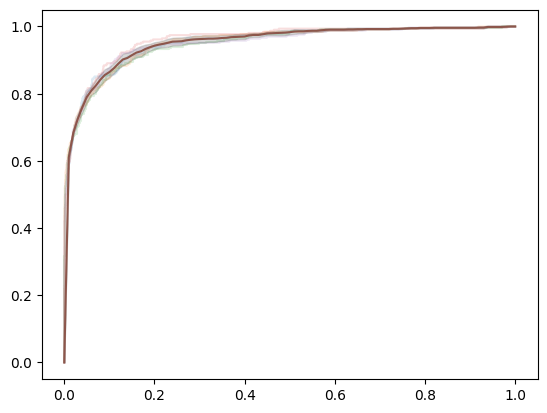

None


In [5]:
print(validation_utils.draw_avg_roc_curve(em,"ensemble", X, y))

In [ ]:
# print(validation_utils.cross_validate(em, X_test, y_test))
# model, name, X, y
ds = datasets['merged'][f'normalized-4']

X_train, y_train, X_test, y_test = ds['X_train'], ds['y_train'], ds['X_test'], ds['y_test']

X = pd.concat([X_train, X_test])
y = np.concatenate([ds['y_train'], ds['y_test']], axis=0)

print(validation_utils.draw_avg_roc_curve(em, "ensemble", X, y))

In [39]:
ds = datasets['merged'][f'normalized-4']

X_train, y_train, X_test, y_test = ds['X_train'], ds['y_train'], ds['X_test'], ds['y_test']

X = pd.concat([X_train, X_test])
y = np.concatenate([ds['y_train'], ds['y_test']], axis=0)

print(validation_utils.draw_avg_roc_curve(em, "ensemble", X, y))

/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [4]:
# models = OrderedDict({
#     'zhang_GBM': zhang_GBM.best_estimator_,
#     'zhang_knn': zhang_knn,
#     'zhang_randforest': zhang_randforest,
#     'zhang_svm': zhang_svm,
#     'zhang_xgboost': zhang_xgboost,
#     'zhang_mlp': zhang_mlp,
#     'zhang_lr': zhang_lr,
#     # 'nardus_GBM': nardus_GBM,
#     'merged_GBM': merged_GBM.best_estimator_,
#     'merged_ensemble': em.best_estimator_
# })

bestandworst = OrderedDict({
    'KNN': knn, # 87.6%, 
    'Random Forest': randforest, # 88.7%
    # 'svm': svm, # 92.9%
    # 'mlp': mlp, # 93.0%
    # 'xgboost': xgboost.best_estimator_, # 93.4%
    'Ensemble': em # 94.1%
})


### Validate models on the merged dataset

In [10]:
# print(validation_utils.cross_validate(zhang_knn, X, y)) # 0.884
# print(validation_utils.cross_validate(zhang_randforest, X, y)) # 0.896
# print(validation_utils.cross_validate(zhang_svm, X, y)) # 0.93
# print(validation_utils.cross_validate(zhang_mlp, X, y)) # 0.935
# print(validation_utils.cross_validate(merged_GBM.best_estimator_, X, y)) # 0.938
# print(validation_utils.cross_validate(em.best_estimator_, X, y)) # 0.943 accuracy

scores_merged, scores_nardus, scores_zhang = [], [], []
kmer = 4

In [ ]:
ds = datasets['merged'][f'normalized-{kmer}']

# this one is trained on only the nardus one

"""
{'learning_rate': 0.15, 'max_depth': 8, 'max_features': 3, 'min_samples_split': 30, 'n_estimators': 130, 'subsample': 0.8}
"""
X_train, y_train, X_test, y_test = ds['X_train'], ds['y_train'], ds['X_test'], ds['y_test']
X = pd.concat([X_train, X_test])
y = np.concatenate([y_train, y_test], axis=0)
x=0
for modelName in bestandworst.keys():
    if x == 6: break
    print(modelName)
    scores_merged.append(validation_utils.cross_validate(bestandworst[modelName], X, y))
    x+=1

In [15]:
print(validation_utils.cross_validate(xgboost.best_estimator_, X, y, scoring='roc_auc'))

XGBClassifier
xgboost


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  1.9min remaining:   28.2s


Accuracy: 0.952 (0.005)
0.952


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.9min finished


In [9]:
print(scores_merged)

NameError: name 'scores_merged' is not defined

### Validate models on only zhang dataset

In [12]:
# only zhang new
# parameters={
#    'n_estimators': 120, 'max_features': 2, 'max_depth': 6, 'random_state': 0, 'min_sample_split': 50, 'subsample': 0.8, 'learning_rate': 0.3
# }
# onlyzhanggradBoost = GradientBoostingClassifier(n_estimators=parameters['n_estimators'], 
#     learning_rate=0.3, max_features=parameters['max_features'], 
#     max_depth=parameters['max_depth'], random_state=parameters['random_state'], 
#     min_samples_split=parameters['min_sample_split'], subsample=parameters['subsample']
# )

# onlyzhanggradBoost.fit(X_train, y_train)
# print(validation_utils.cross_validate(onlyzhanggradBoost, X_test, y_test))

ds = datasets['zhang'][f'normalized-{kmer}']

X_train, y_train, X_test, y_test = ds['X_train'], ds['y_train'], ds['X_test'], ds['y_test']
for modelName in bestandworst:
    print(modelName)
    scores_zhang.append(validation_utils.cross_validate(bestandworst[modelName], X_test, y_test))

zhang_knn
BalancedBaggingClassifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.5s finished


Accuracy: 0.866 (0.031)
tn: 1259, fp: 359, fn: 228, tp: 20
zhang_randforest
BalancedBaggingClassifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy: 0.906 (0.023)
tn: 1600, fp: 18, fn: 248, tp: 0
merged_GBM
GradientBoostingClassifier
gradboost


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy: 0.947 (0.015)
tn: 1616, fp: 2, fn: 33, tp: 215
merged_ensemble
StackingCVClassifier


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.5min finished


Accuracy: 0.942 (0.014)
tn: 1601, fp: 17, fn: 9, tp: 239


In [45]:
print(scores_zhang)

[]


### Validate models only on nardus dataset

In [ ]:
ds = datasets['nardus'][f'normalized-{kmer}']

X_train, y_train, X_test, y_test = ds['X_train'], ds['y_train'], ds['X_test'], ds['y_test']
print("acc on nardus")

parameters={
   'n_estimators': 120, 'max_features': 2, 'max_depth': 6, 'random_state': 0, 'min_sample_split': 50, 'subsample': 0.8, 'learning_rate': 0.3
}

param_test1 = {'n_estimators':range(100,140,10), 'learning_rate':[0.1,0.15,0.2], 'subsample':[0.8,0.85,0.9], 'max_depth':range(6,9,1), 'min_samples_split':range(10,40,10), 'max_features':range(2, 5)}

onlynardgradBoost = GridSearchCV(estimator = GradientBoostingClassifier(
    n_estimators=parameters['n_estimators'], max_features=parameters['max_features'], random_state=parameters['random_state']), 
param_grid = param_test1, scoring='roc_auc',n_jobs=-1, cv=5, verbose=10)

onlynardgradBoost.fit(X_train, y_train)

In [30]:
pickle.dump(onlynardgradBoost, open('models/curr_models/onlynardgradBoost.pkl', 'wb'))

In [13]:
ds = datasets['nardus'][f'normalized-{kmer}']

X_train, y_train, X_test, y_test = ds['X_train'], ds['y_train'], ds['X_test'], ds['y_test']

for modelName in bestandworst:
    print(modelName)
    scores_nardus.append(validation_utils.cross_validate(bestandworst[modelName], X_test, y_test))

zhang_knn
BalancedBaggingClassifier


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy: 0.668 (0.085)
tn: 237, fp: 43, fn: 81, tp: 9
zhang_randforest
BalancedBaggingClassifier


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy: 0.657 (0.071)
tn: 279, fp: 1, fn: 90, tp: 0
merged_GBM
GradientBoostingClassifier
gradboost


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Accuracy: 0.752 (0.033)
tn: 276, fp: 4, fn: 7, tp: 83
merged_ensemble
StackingCVClassifier


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   41.3s finished


Accuracy: 0.687 (0.056)
tn: 270, fp: 10, fn: 11, tp: 79


In [10]:
print(scores_merged)
print(scores_nardus)
print(scores_zhang)

[0.825, 0.875, 0.918, 0.911]
[]
[]


### Draw validation

In [6]:
# these were autogenerated but saved here for convenience
# scores_merged = [0.875, 0.887, 0.941]
print(scores_merged)

[0.875, 0.887, 0.941]


NameError: name 'scores_nardus' is not defined

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


96.1 0.0
90.7 1.0
89.5 2.0


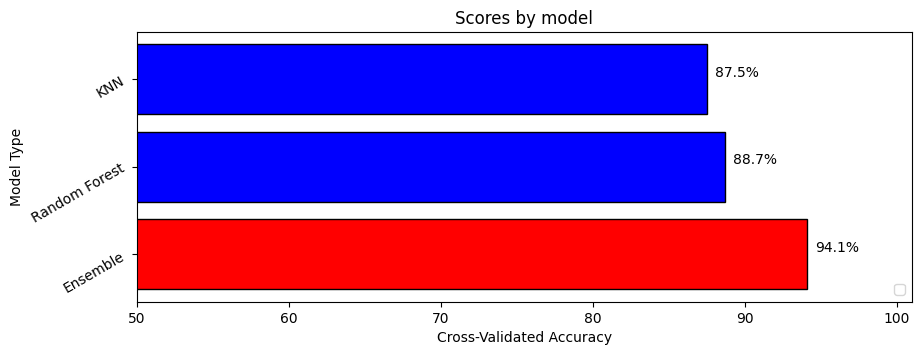

In [7]:
merged_dc = OrderedDict(sorted(OrderedDict(map(lambda i,j : (i,j) , bestandworst.keys(),scores_merged)).items(), key=lambda x: x[1], reverse=True))
# nardus_dc = OrderedDict(sorted(OrderedDict(map(lambda i,j : (i,j) , bestandworst.keys(),scores_nardus)).items(), key=lambda x: x[1], reverse=True))
# zhang_dc = OrderedDict(sorted(OrderedDict(map(lambda i,j : (i,j) , bestandworst.keys(),scores_zhang)).items(), key=lambda x: x[1], reverse=True))

validation_utils.draw_accuracies(bestandworst, None, None, merged_dc)

In [ ]:
validation_utils.draw_accuracies(bestandworst, None, None, nardus_dc)
validation_utils.draw_accuracies(bestandworst, None, None, zhang_dc)

BalancedBaggingClassifier(base_estimator=KNeighborsClassifier(n_jobs=1,
                                                              n_neighbors=1),
                          n_jobs=1)
fit done
auc split:  0.9648249712235086
fit done
auc split:  0.972185803068156
fit done
auc split:  0.9548917078603387
fit done
auc split:  0.9592630231857874
fit done
auc split:  0.9607172781135914
0.9623765566902766
time for CV:  1.7443749904632568
BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features='sqrt'))
fit done
auc split:  0.959398740605322
fit done
auc split:  0.9641708649061591
fit done
auc split:  0.9524603856900021
fit done
auc split:  0.9459650707618187
fit done
auc split:  0.9557760787599496
0.9555542281446503
time for CV:  1.5419037342071533
GradientBoostingClassifier(learning_rate=0.15, max_depth=8, max_features=3,
                           min_samples_split=30, n_estimators=130,
                           random_state=0, subsample=0.8)
fit done
auc split:  0.96

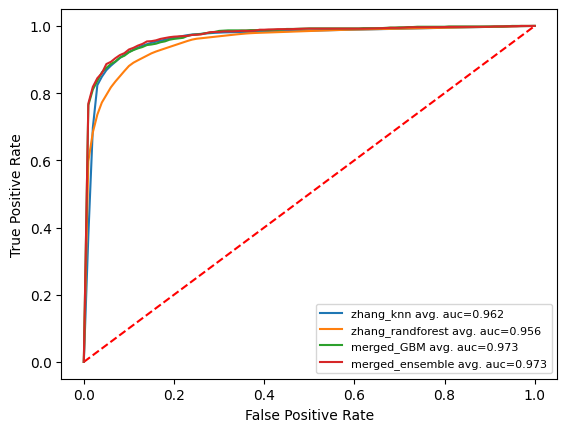

In [30]:
ds = datasets['zhang'][f'normalized-4']
X = pd.concat([ds['X_train'], ds['X_test']], axis=0)
Y = np.concatenate([ds['y_train'], ds['y_test']], axis=0)

validation_utils.draw_avg_roc_multiple(bestandworst, X, Y)

GradientBoostingClassifier(max_depth=9, max_features=2, min_samples_split=20,
                           n_estimators=140, random_state=0, subsample=0.9)
fit done
auc split:  0.7113195883786044
fit done
auc split:  0.7192962838719297
fit done
auc split:  0.7116198608708455
fit done
auc split:  0.709811265330102
fit done
auc split:  0.7658105939004815
0.7235715184703926
time for CV:  1.5528950691223145
GradientBoostingClassifier(learning_rate=0.15, max_depth=8, max_features=3,
                           min_samples_split=30, n_estimators=130,
                           random_state=0, subsample=0.8)
fit done
auc split:  0.6916112141376677
fit done
auc split:  0.7147862387714786
fit done
auc split:  0.6807758842798778
fit done
auc split:  0.7069471983549974
fit done
auc split:  0.7439807383627608
0.7076202547813565
time for CV:  1.3861949443817139
BalancedBaggingClassifier(base_estimator=KNeighborsClassifier(n_jobs=1,
                                                              n_neighb

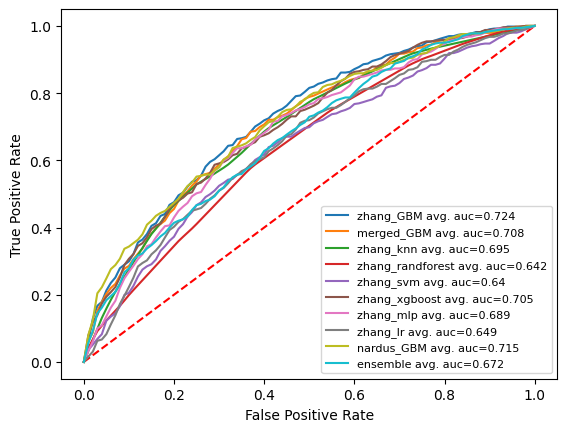

In [19]:
ds = datasets['nardus'][f'normalized-4']
X = pd.concat([ds['X_train'], ds['X_test']], axis=0)
Y = np.concatenate([ds['y_train'], ds['y_test']], axis=0)

validation_utils.draw_avg_roc_multiple(models, X, Y)

BalancedBaggingClassifier(base_estimator=KNeighborsClassifier(n_jobs=1,
                                                              n_neighbors=1),
                          n_jobs=1)
fit done
auc split:  0.9298784722222222
fit done
auc split:  0.9284667713239143
fit done
auc split:  0.9307861545756282
fit done
auc split:  0.9452706323687032
fit done
auc split:  0.932595502327601
0.9333995065636138
time for CV:  2.24573016166687
BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features='sqrt'))
fit done
auc split:  0.926518683862434
fit done
auc split:  0.9142141984999128
fit done
auc split:  0.916303461356093
fit done
auc split:  0.9301357040108309
fit done
auc split:  0.9227002527879039
0.921974460103435
time for CV:  1.9907898902893066
StackingCVClassifier(classifiers=[MLPClassifier(hidden_layer_sizes=(256, 128,
                                                                    64, 32),
                                                random_state=42),
         

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   51.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Fitting classifier3: svc (3/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


fit done
auc split:  0.9538988095238096
Fitting 3 classifiers...
Fitting classifier1: mlpclassifier (1/3)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   47.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Fitting classifier3: svc (3/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


fit done
auc split:  0.9524777603349033
Fitting 3 classifiers...
Fitting classifier1: mlpclassifier (1/3)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Fitting classifier3: svc (3/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.3s finished


fit done
auc split:  0.9405841631104789
Fitting 3 classifiers...
Fitting classifier1: mlpclassifier (1/3)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Fitting classifier2: xgbclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   44.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Fitting classifier3: svc (3/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


KeyboardInterrupt: 

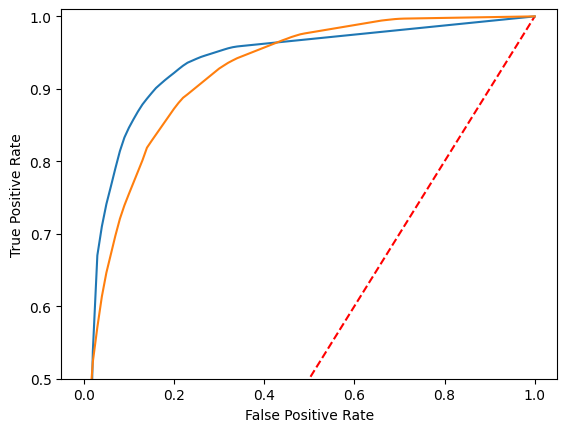

In [34]:
ds = datasets['merged'][f'normalized-4']
X = pd.concat([ds['X_train'], ds['X_test']], axis=0)
Y = np.concatenate([ds['y_train'], ds['y_test']], axis=0)

l = validation_utils.draw_avg_roc_multiple(bestandworst, X, Y)

BalancedBaggingClassifier
precision recall: 0.7986487842724114
BalancedBaggingClassifier
precision recall: 0.7425944482785196
StackingCVClassifier


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


precision recall: 0.8506949901676641


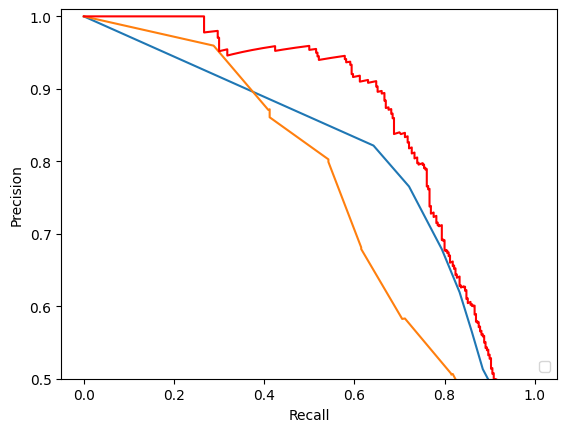

KNN
0.8759363295880149
Random Forest
0.87687265917603
Ensemble
0.9321161048689138


In [5]:
ds = datasets['merged'][f'normalized-4']
X = pd.concat([ds['X_train'], ds['X_test']])
y = np.concatenate([ds['y_train'], ds['y_test']], axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

validation_utils.draw_prec_roc_curve_multiple(bestandworst, X_test, y_test)
for key in bestandworst:
    print(key)
    print(accuracy_score(y_test, bestandworst[key].predict(X_test)))

In [7]:
print(ds['X_test'])

          cccc      accc      cctg      actg      attg      tagg      aagc  \
5515  0.052900  0.083911  0.157242  0.177672  0.268515  0.195549  0.233127   
1208  0.264151  0.603774  0.452830  0.415094  0.679245  0.226415  0.452830   
7722  0.270975  0.409297  0.258503  0.142857  0.015873  0.007937  0.167800   
2085  0.173244  0.172575  0.252843  0.113043  0.037458  0.023411  0.094983   
2458  0.880000  0.360000  0.320000  0.440000  0.240000  0.200000  0.160000   
...        ...       ...       ...       ...       ...       ...       ...   
2260  0.140653  0.232305  0.358439  0.176044  0.093466  0.016334  0.242287   
8611  0.608696  0.434783  0.434783  0.347826  0.391304  0.173913  0.956522   
8983  0.018692  0.065421  0.112150  0.420561  0.607477  0.000000  0.196262   
3678  0.007692  0.100000  0.146154  0.223077  0.530769  0.069231  0.392308   
1034  0.750000  0.390625  0.328125  0.171875  0.046875  0.078125  0.171875   

          tcga      tctc      tgcc  ...      tcac      cgcg    

In [15]:
print(l)

[0.931, 0.915, 0.953]
